In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as pyplot
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import time
from torchsummary import summary
from sklearn.model_selection import train_test_split

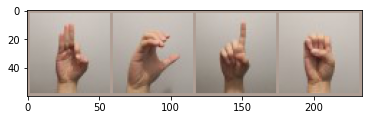

silence vertical scratch W scratch circle scratch
The one-hot classes are: 
tensor([[0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.]])
0 1.76710844039917 0.375
1 1.6409106254577637 0.375
2 1.4297683238983154 0.375
3 1.0813310146331787 0.75
4 0.8080976009368896 0.75
5 4.669608116149902 0.375
6 1.771343469619751 0.125
7 1.7464288473129272 0.25
8 1.7248446941375732 0.25
9 1.7001864910125732 0.25
10 1.6670805215835571 0.25
11 1.6150093078613281 0.25
12 1.5441279411315918 0.25
13 1.4349883794784546 0.25
14 1.2671045064926147 0.5
15 1.018790602684021 0.5
16 0.657951295375824 0.875
17 0.32361093163490295 0.875
18 0.916145384311676 0.625
19 4.642516136169434 0.375
20 1.6539428234100342 0.25
21 1.4686920642852783 0.5
22 1.2798583507537842 0.5
23 1.5382649898529053 0.5
24 1.3275666236877441 0.375
25 0.7522203922271729 0.875
26 0.9479587078094482 0.625


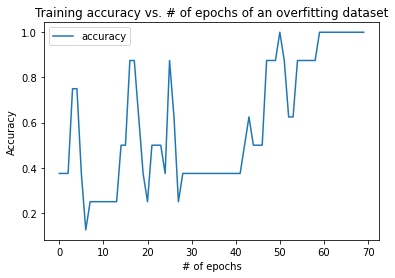

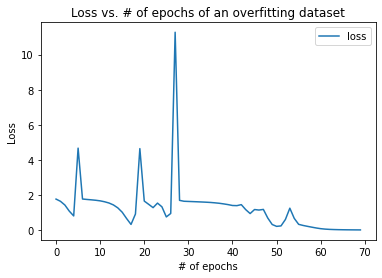

In [7]:
# Hyperparameters
numOfConvLayers = 4
numOfKernels = 12
numOfNeurons = 12
learningRate = 0.1
batchSize = 48
test_split = 0.35
numOfEpochs = 70
kernelSize = 3
activation = F.relu       
optimizer_func = torch.optim.SGD
loss_fnc = nn.CrossEntropyLoss()
batchNorm = True
numOfFCLayers = 2
seed = 42


# Input overfit, train, val, test dataset 
# Load un-normalized data to compute mean and standard deviation.
path = '/content/drive/My Drive/Colab Notebooks/Assignment 4/My_ASL'
overfit_path = '/content/drive/My Drive/Colab Notebooks/Assignment 4/My_ASL'
dataset_raw = torchvision.datasets.ImageFolder(\
            root=path, \
            transform=transforms.Compose([transforms.ToTensor()]))
loader = DataLoader(dataset_raw, batch_size=len(dataset_raw))
data = next(iter(loader))
mean = torch.mean(data[0], (0,2,3))
std = torch.std(data[0], (0,2,3))
overfit_raw = torchvision.datasets.ImageFolder(\
            root=overfit_path, \
            transform=transforms.Compose([transforms.ToTensor()]))
loader = DataLoader(overfit_raw, batch_size=len(overfit_raw))
data = next(iter(loader))
mean_overfit = torch.mean(data[0], (0,2,3))
std_overfit = torch.std(data[0], (0,2,3))

# Normalized dataset
dataset = torchvision.datasets.ImageFolder(\
            root=path, \
            transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)]))
overfit_set = torchvision.datasets.ImageFolder(\
            root=overfit_path, \
            transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean_overfit, std_overfit)]))

# create train, val, test, and overfit dataset
testSize = 0.2
valSize = 0.3
train_set, test_set = train_test_split(dataset, test_size=testSize, random_state=seed)   # split test
train_set, val_set = train_test_split(train_set, test_size=valSize/(1-testSize), random_state=seed)   # split train to train and val

train_loader = DataLoader(train_set, batch_size=batchSize, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batchSize, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batchSize, shuffle=True)
overfit_loader = DataLoader(overfit_set, batch_size=batchSize, shuffle=True)

# Check the ground truth of the images
def imshow(img):
  img[0] = img[0] * std[0] + mean[0]     # De-normalize
  img[1] = img[1] * std[1] + mean[1]     # De-normalize
  img[2] = img[2] * std[2] + mean[2]     # De-normalize
  npimg = img.numpy()
  pyplot.imshow(np.transpose(npimg, (1, 2, 0)))
  pyplot.show()
 
dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images[0:4]))
classes = ['finertip tap', 'fingernail tap', 'vertical scratch', 'W scratch', 'circle scratch', 'silence'] 
print(' '.join('%5s' % classes[labels[j]] for j in range(4))) 

# One-hot encode the classes
oneh_encoder = OneHotEncoder()
oneh_classes = torch.Tensor(oneh_encoder.fit_transform(np.asarray(classes).reshape(-1, 1)).toarray())
print("The one-hot classes are: ")
print (oneh_classes)




# CNN Model
# Fixed Hyperparameters: square size image input, two fully connected layers
# TODO: Error checking
# TODO: unit testing 
class CNN(nn.Module):
  def __init__(self, input_dim, numOfKernels, numOfNeurons, kernelSize, numOfConvLayers, batchNorm):
    super(CNN, self).__init__()         
    self.numOfKernels = numOfKernels
    self.batchNorm = batchNorm
    self.numOfConvLayers = numOfConvLayers

    # Convolutional Layers
    self.conv1 = nn.Conv2d(3,numOfKernels, kernelSize)
    self.conv2 = nn.Conv2d(numOfKernels,numOfKernels, kernelSize)
    self.conv_BN = nn.BatchNorm2d(numOfKernels)

    # Determine the output size after the convolutional layer
    fullLayerSize = input_dim
    for i in range (self.numOfConvLayers):
      fullLayerSize = (fullLayerSize-kernelSize+1)//2

    # Fully connected layers
    self.fc1 = nn.Linear(numOfKernels*fullLayerSize*fullLayerSize, numOfNeurons)
    self.fc1_BN = nn.BatchNorm1d(numOfNeurons)
    self.pool = nn.MaxPool2d(2,2)
    self.fc2 = nn.Linear(numOfNeurons, 6)
    self.fc2_BN = nn.BatchNorm1d(6)

  def forward(self, x):
    if self.batchNorm == True:
      x = self.pool(activation(self.conv_BN(self.conv1(x))))
      for i in range (self.numOfConvLayers - 1):
        x = self.pool(activation(self.conv_BN(self.conv2(x))))
      x = x.view(-1, x.shape[1]*x.shape[2]*x.shape[3])
      x = activation(self.fc1_BN(self.fc1(x)))
      x = self.fc2_BN(self.fc2(x))
    else: 
      x = self.pool(activation(self.conv1(x)))
      for i in range (self.numOfConvLayers - 1):
        x = self.pool(activation(self.conv2(x)))
      x = x.view(-1, x.shape[1]*x.shape[2]*x.shape[3])
      x = activation(self.fc1(x))
      x = self.fc2(x)
    return x



# Evaluation functions
def evaluate(model, data_loader, batchNorm):   # used on validation and test set
  total_corr = 0
  totalLoss = 0
  if batchNorm:
    model.eval()
  else:
    model.train()
  for i, (inputs, labels) in enumerate(data_loader):
    oneh_labels = oneh_classes[labels]
    outputs = model(inputs)
    if str(loss_fnc) == "CrossEntropyLoss()":                # CrossEntropyLoss does not accept one-hot labels
      loss = loss_fnc(input=outputs, target=labels) 
    else: 
      loss = loss_fnc(input=outputs, target=oneh_labels) 
    total_corr += numOfCorrectPredictions(outputs, labels) 
    totalLoss += loss.item()
  accuracy = float(total_corr)/len(data_loader.dataset)
  loss = totalLoss/len(data_loader)
  return (loss, accuracy)

def numOfCorrectPredictions(Y, L):
  result = Y.argmax(1)      # Get the maximum value in each output and compare it to its label
  return (result == L).sum()



# Train Overfit Model
def overfit_training (data_loader, model, optimizer):
  trainAccuracies = []
  trainLosses = []
  start_time = time.time()
  model.train()
  for epoch in range(numOfEpochs):
    totalLoss = 0
    totalCorrect = 0
    for i, (inputs, labels) in enumerate(data_loader):
      optimizer.zero_grad() 
      outputs = model(inputs)                                  # Get outputs
      oneh_labels = oneh_classes[labels]                       # Get one hot labels
      if str(loss_fnc) == "CrossEntropyLoss()":                # CrossEntropyLoss does not accept one-hot labels
        loss = loss_fnc(input=outputs, target=labels) 
      else: 
        loss = loss_fnc(input=outputs, target=oneh_labels)  
      loss.backward()                                          # Compute loss gradients
      optimizer.step()                                         # Adjust weights 
      totalCorrect += numOfCorrectPredictions(outputs, labels)
      totalLoss += loss.item()
    
    # Here, my accuracy at each epoch is the average accuracy across the entire epoch;
    # my loss at each epoch is the average loss over the entire epoch
    avg_accuracy = float(totalCorrect) / len(data_loader.dataset) 
    avg_loss = totalLoss/len(data_loader)
    print(epoch, avg_loss, avg_accuracy)
    trainAccuracies += [avg_accuracy]  
    trainLosses += [avg_loss]
  print("total time: ")
  print(time.time()-start_time)
  return trainAccuracies, trainLosses


# Traning loop function for full dataset
def full_training (train_loader, val_loader, test_loader, model, optimizer):
  trainAccuracies = []
  validAccuracies = []
  trainLosses = []
  validLosses = []
  start_time = time.time()
  model.train()
  for epoch in range(numOfEpochs):
    totalCorrect = 0
    totalLoss = 0
    for i, (inputs, labels) in enumerate(train_loader):
      optimizer.zero_grad() 
      outputs = model(inputs)                                  # Get outputs
      oneh_labels = oneh_classes[labels]                       # Get one hot labels
      if str(loss_fnc) == "CrossEntropyLoss()":                # CrossEntropyLoss does not accept one-hot labels
        loss = loss_fnc(input=outputs, target=labels) 
      else: 
        loss = loss_fnc(input=outputs, target=oneh_labels) 
      loss.backward()                                          # Compute loss gradients
      optimizer.step()                                         # Adjust weights 
      totalCorrect += numOfCorrectPredictions(outputs, labels)
      totalLoss += loss.item()

    # For every epoch, compute the training accuracy and loss
    # Here, my accuracy at each epoch is the average accuracy across the entire epoch;
    # my loss at each epoch is the average loss over the entire epoch
    avg_train_accuracy = float(totalCorrect) / len(train_loader.dataset)
    avg_train_loss = totalLoss/len(train_loader)

    # For every epoch, get accuracy, and loss of the validation data
    (valid_loss, valid_accuracy) = evaluate(model, val_loader)
    print(epoch, valid_loss, valid_accuracy)
    trainAccuracies += [avg_train_accuracy]  
    trainLosses += [avg_train_loss]
    validAccuracies += [valid_accuracy]  
    validLosses += [valid_loss]

  print("total time: ")     # print total time 
  print(time.time()-start_time)
  (test_loss, test_accuracy) = evaluate(model, test_loader)    # evaluate the test data
  print("the test accuracy and loss after CNN model is ", test_accuracy, test_loss)

  return trainAccuracies, trainLosses, validAccuracies, validLosses


# Plotting
# Plot the overfitting results
def plot_overfit(trainAccuracies, trainLosses):
  # Accuracy plot
  pyplot.plot(trainAccuracies, label='accuracy')
  pyplot.legend()
  pyplot.ylabel('Accuracy')
  pyplot.xlabel('# of epochs')
  pyplot.title('Training accuracy vs. # of epochs of an overfitting dataset')
  pyplot.show()

  # Loss plot
  pyplot.plot(trainLosses, label='loss')
  pyplot.legend()
  pyplot.ylabel('Loss')
  pyplot.xlabel('# of epochs')
  pyplot.title('Loss vs. # of epochs of an overfitting dataset')
  pyplot.show()

# Plot the full data results 
def plot_full_data(trainAccuracies, trainLosses, validAccuracies, validLosses):
  # Accuracy plot
  pyplot.plot(trainAccuracies, label='training')
  pyplot.plot(validAccuracies, label='validation')
  pyplot.legend()
  pyplot.ylabel('Accuracy')
  pyplot.xlabel('# of epochs')
  pyplot.title('Training accuracy vs. # of epochs of the full dataset')
  pyplot.show()

  # Loss plot
  pyplot.plot(trainLosses, label='traning')
  pyplot.plot(validLosses, label='validation')
  pyplot.legend()
  pyplot.ylabel('Loss')
  pyplot.xlabel('# of epochs')
  pyplot.title('Loss vs. # of epochs of the full dataset')
  pyplot.show()




######################################### LOAD AND CALL THE MODEL HERE ##############################################
torch.manual_seed(seed)
model = CNN(input_dim=56, numOfKernels=8, numOfNeurons=100, kernelSize=3, numOfConvLayers=2, batchNorm=False)    # Load model 
optimizer = optimizer_func(model.parameters(),lr=learningRate)

trainAccuracies, trainLosses = overfit_training(train_loader, model, optimizer)
plot_overfit(trainAccuracies, trainLosses)
